In [11]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import expit
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import io
import imageio
from matplotlib import cm


import systems
import torch
import torchsde
import utils


In [12]:
def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

xrange, yrange, zrange = ((-30,30),(-40,40),(0,70))
cent = np.expand_dims(np.array([np.mean(xrange),np.mean(yrange),np.mean(zrange)]),axis=1)
cent = np.expand_dims(np.array([0,0,35]),axis=1)

abc = 2*np.expand_dims(np.array([30,40,35]),axis=1)
pnts = sample_spherical(1500,ndim=3)*abc + cent
pnts[:,0]

array([-23.4082874 , -72.74832133,  24.88808456])

In [13]:
#main run
brownian_size = 3
batch_size = 1
t_size = 520
tf = .25
sys = systems.Lorentz_SDE(brownian_size,batch_size,noise_amp=0.0)
y0 = torch.tensor(pnts[:,0],dtype=torch.float)# interesting loop[ 1.35641339, -0.58946927, -2.27060091]
y0=y0.repeat(batch_size,1)
ts = torch.linspace(0, tf, t_size)
# Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
# ys will have shape (t_size, batch_size, state_size)
ys = torchsde.sdeint(sys, y0, ts)
yy = np.array(ys.detach())

#noisy
batch_size = 500
init_spread = 0.01
noise_amp = 0.01
y0 = y0.repeat(batch_size,1)
y0 += init_spread*torch.randn_like(y0)
sys2 = systems.Lorentz_SDE(brownian_size,batch_size,noise_amp=noise_amp)
ys = torchsde.sdeint(sys2, y0, ts)
yo = np.array(ys.detach())


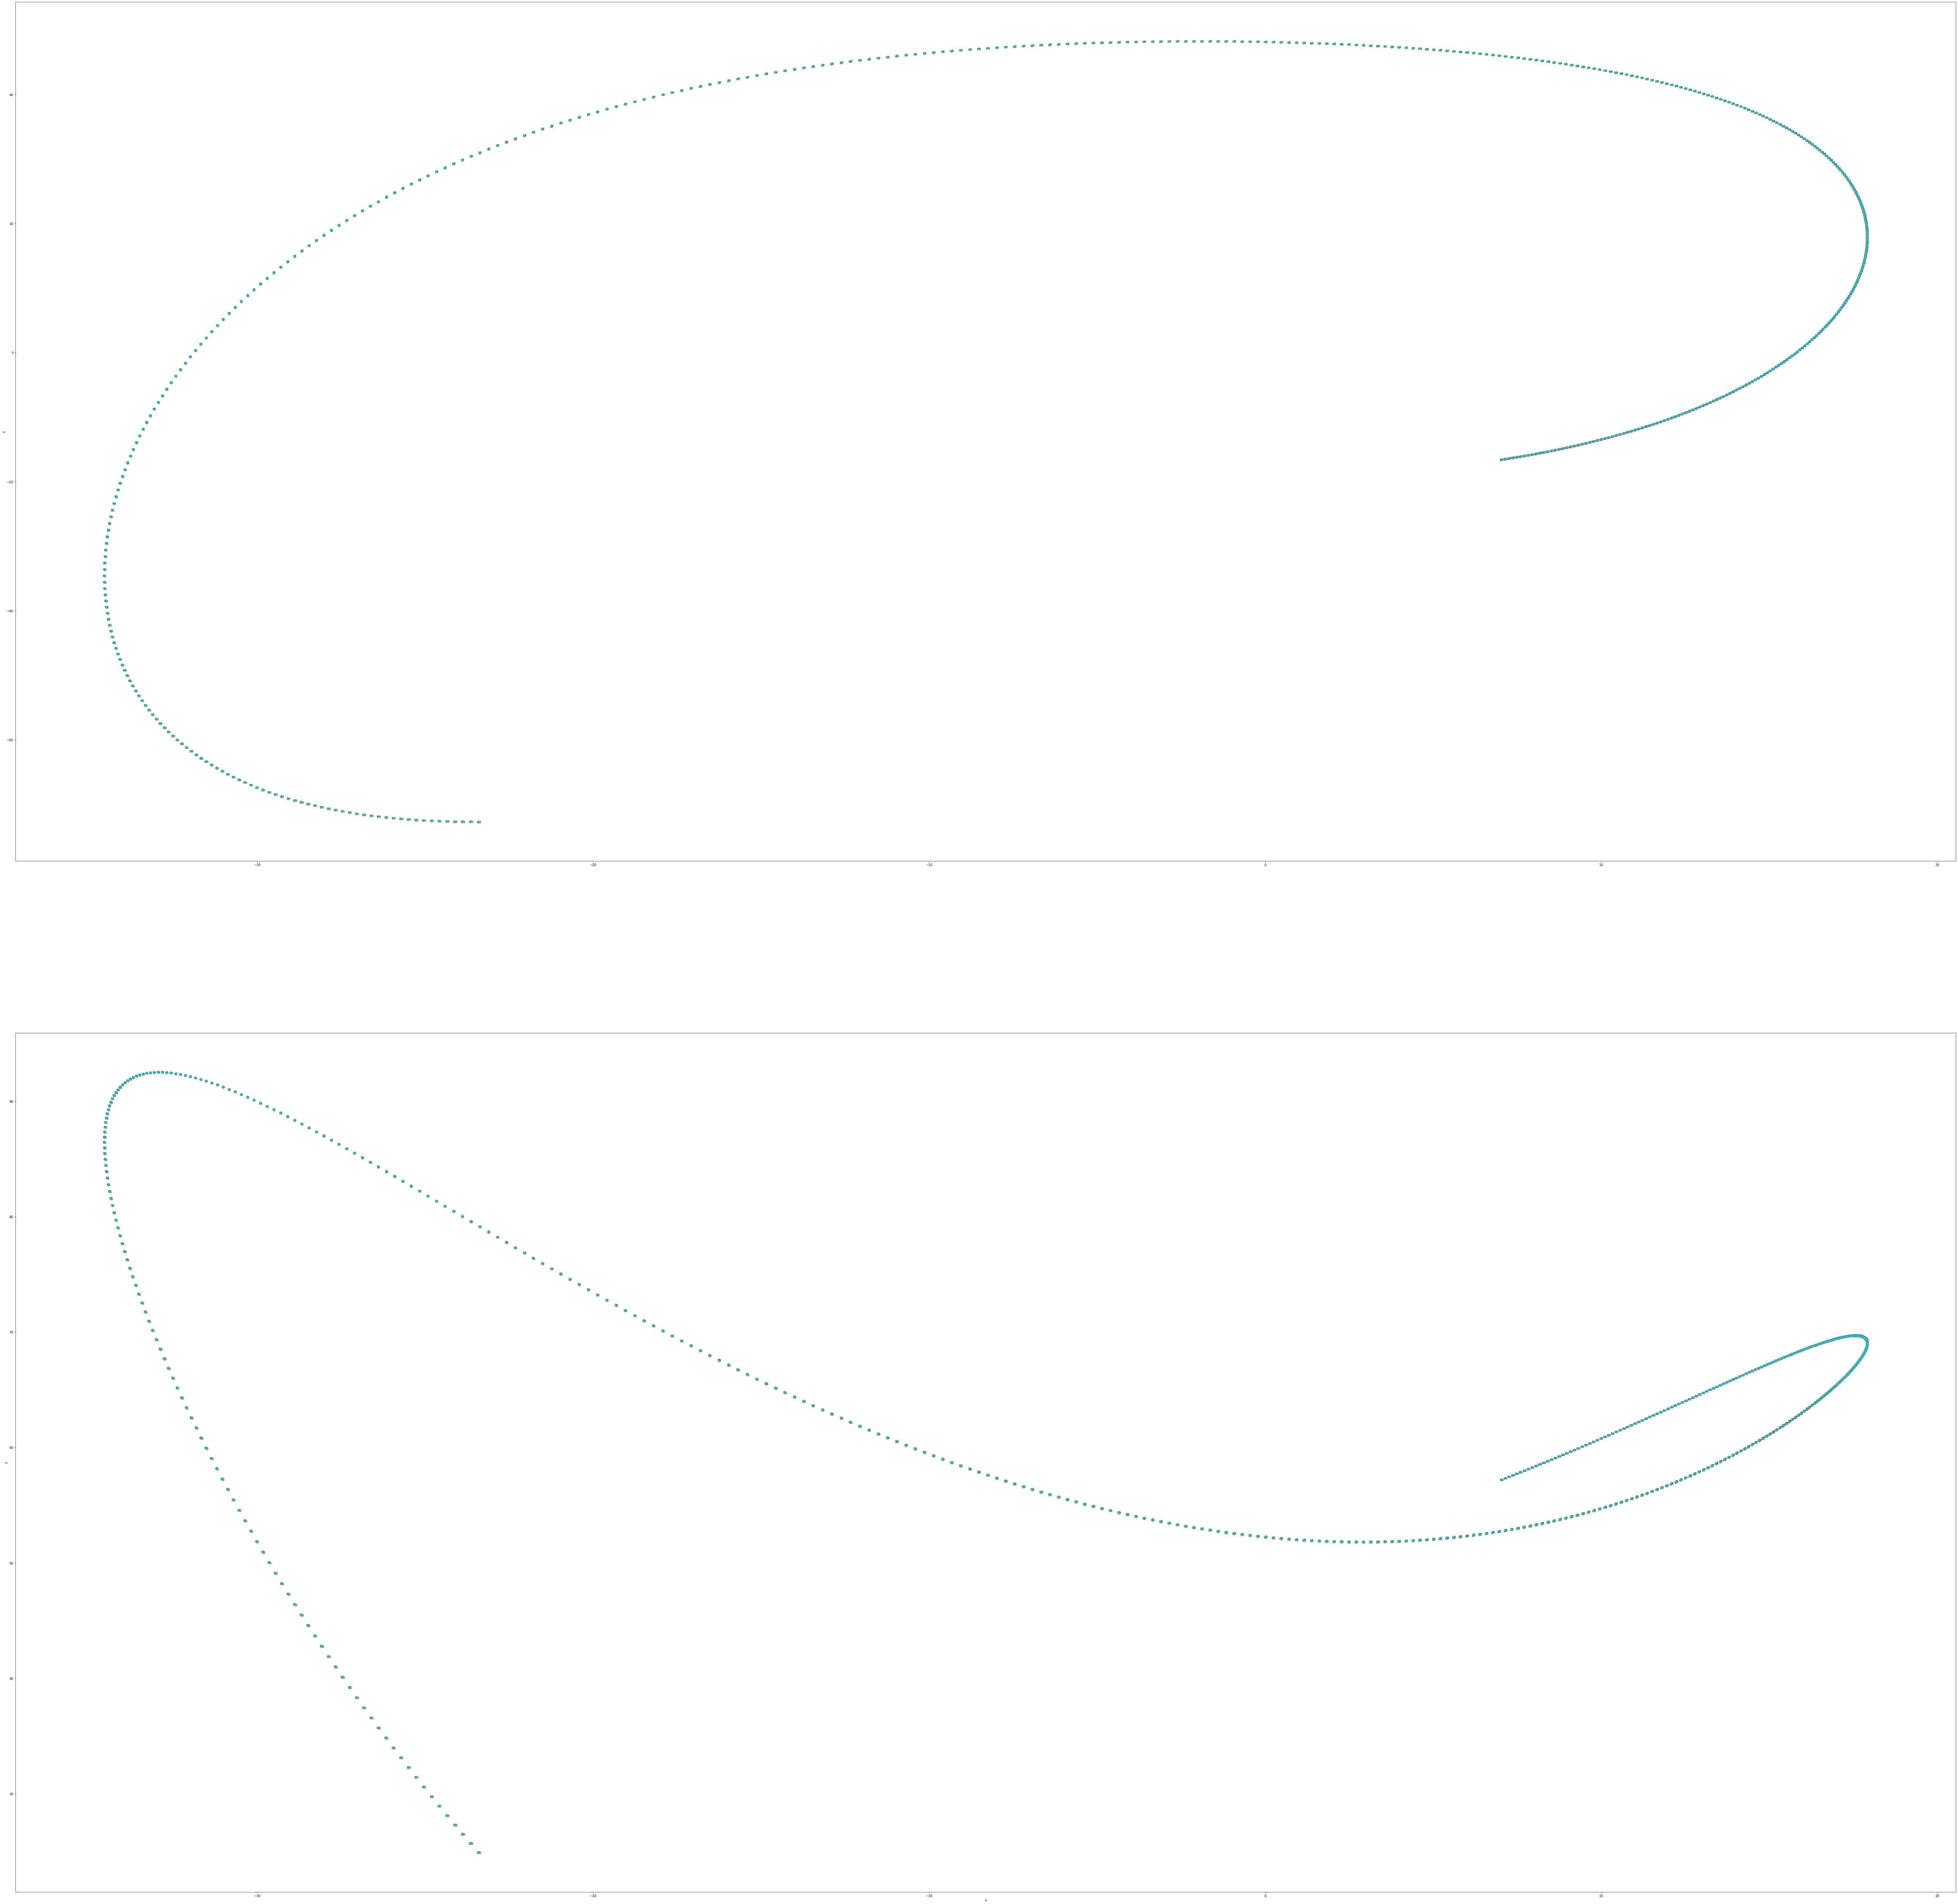

In [14]:
utils.plt3(yo)

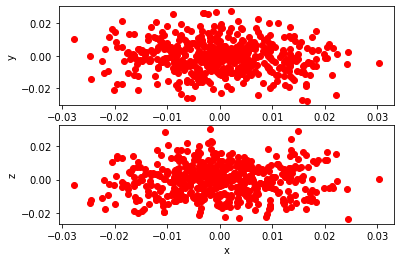

In [15]:
plt.figure()
plt.subplot(2,1,1)
plt.scatter(yo[0,:,0]-yy[0,:,0],yo[0,:,1]-yy[0,:,1],c='r')
plt.ylabel('y')
plt.subplot(2,1,2)
plt.scatter(yo[0,:,0]-yy[0,:,0],yo[0,:,2]-yy[0,:,2],c='r')
plt.ylabel('z')
plt.xlabel('x')
plt.show()

In [16]:
d = 3
q_bounds = [0,500]

dt = float(ts[1])
initial_sigma = init_spread
#Sigma = initial_sigma #for the arrival
Sigma = initial_sigma*np.eye(d) #for the plane

es = []
vs = []
Js = []
dts = []
Rss = []
print(Sigma)
rotation_manager = utils.rot_keeper(d=d)

for q in range(q_bounds[0],q_bounds[1],1):
    print(f'frame: {q}', end='\r')
    f = np.array(sys.f(0,torch.tensor(yy[q,[0],:]))[0])
    nf = np.sqrt(np.sum(f**2))
    Rs=rotation_manager.get_rot(f)
    ooy = Rs@yy[q,0,:]
    J = np.array(sys.J(0,torch.tensor(yy[[q],[0],:]))[0])
    Jr = Rs.T@J@Rs
    Rss.append(Rs)
    Js.append(Jr.copy())
    Sigma += dt**2*Jr.T@Sigma@Jr + dt*noise_amp*np.eye(d)
    e,v=np.linalg.eig(Jr[1:,1:])
    es.append(e.copy())
    vs.append(v.copy())
    dts.append(Jr[0,1:].copy())
print(Sigma)


[[0.01 0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.01]]
[[ 1.35780885e-02 -8.56988462e-05 -2.22125059e-04]
 [-8.56988462e-05  1.53541357e-02 -2.62272574e-04]
 [-2.22125059e-04 -2.62272574e-04  1.37781205e-02]]


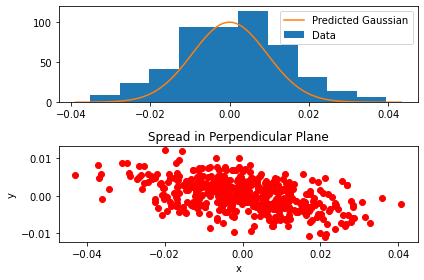

[0.01355141 0.01346671 0.00401494]
[[ 1.35780885e-02 -8.56988462e-05 -2.22125059e-04]
 [-8.56988462e-05  1.53541357e-02 -2.62272574e-04]
 [-2.22125059e-04 -2.62272574e-04  1.37781205e-02]]


In [17]:
tR = Rss[-1]
dy = yo[q_bounds[1],:,:]-yy[q_bounds[1],:,:]
dyR = tR@dy.T
plt.figure()
ax = plt.subplot(2,1,1)
ax.hist(dyR[0])
xl,xh = ax.get_xbound()
xe = np.linspace(xl,xh,100)
ye = np.exp(-xe**2/np.sum(Sigma[:,2])**2)
plt.plot(xe,ye*100)
plt.legend(['Predicted Gaussian','Data'])
plt.subplot(2,1,2)
plt.title('Spread in Perpendicular Plane')
plt.scatter(dyR[1],dyR[2],c='r')
plt.ylabel('y')
plt.xlabel('x')
plt.tight_layout()

plt.show()
print(np.std(dyR,axis=1))
print(Sigma)

In [69]:
np.sum(Sigma[:,2])

0.017362293818339963